<a href="https://colab.research.google.com/github/sy-hwang/DeepLearningZeroToAll/blob/master/standalone/lab_08_cifar100_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import argparse
import torch.optim as optim
import torch.nn as nn
import torch.utils.data.dataloader

Hyperparameter

In [3]:
parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.lr = 0.001
args.trainsize = 0.8
args.num_workers = 2
args.batch_size = 1024
args.in_dim = 32*32*3
args.in_channels = 3
args.out_dim=10
args.hidden_dim=100
args.hidden_layer =3
args.act = 'relu'
args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
args.momentum = 0.9
args.epoch=5
args.optimizer = 'adam'
args.dropout_prob = 0.5
args.weight_decay=0.0001
args.model ='MLP'
print(args)

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

Namespace(lr=0.001, trainsize=0.8, num_workers=2, batch_size=1024, in_dim=3072, in_channels=3, out_dim=10, hidden_dim=100, hidden_layer=3, act='relu', device=device(type='cuda', index=0), momentum=0.9, epoch=5, optimizer='adam', dropout_prob=0.5, weight_decay=0.0001, model='MLP')


In [4]:
!pip install neptune-client psutil
import neptune

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 501.5/501.5 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.5 MB/s eta 0:00:00
  Created wheel for bravado-core: filename=bravado_core-6.1.1-py2.py3-none-any.whl size=67675 sha256=954c7606117081c40a9a29620d42a35583d35f71347ceef8a299c81583959f9f
  Stored in directory: /root/.cache/pip/wheels/42/35/4a/44ec4c358db21a5d63e

[neptune] [warning] NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/


Data generation

In [38]:
# 데이터 증강 파이프라인
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),               # 랜덤 크롭 + 패딩
    transforms.RandomHorizontalFlip(),                  # 랜덤 좌우 반전
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 색상 변환
    transforms.RandomErasing(p=0.5),
    transforms.ToTensor(),                              # 텐서로 변환
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 정규화
])

# 검증 및 테스트 시에는 데이터 증강 없이 정규화만 적용
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-100 데이터셋 로드
trainSet = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
trainSize = int(args.trainsize * len(trainSet))
validateSize = len(trainSet) - trainSize

# 학습 및 검증 데이터셋 분리
trainSet, validateSet = torch.utils.data.random_split(trainSet, [trainSize, validateSize])

# 검증 세트는 데이터 증강 없이
validateSet.dataset.transform = test_transform

# 테스트 데이터셋
testSet = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)


Files already downloaded and verified
Files already downloaded and verified


In [39]:
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)
validateLoader = torch.utils.data.DataLoader(validateSet, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)
testLoader = torch.utils.data.DataLoader(testSet, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)

print(f"set Nums : {len(trainSet), len(validateSet), len(testSet)}")
print(f"batchSize: {args.batch_size} / num Batches : {len(trainSet)//args.batch_size}, {len(validateSet)//args.batch_size}, {len(testSet)//args.batch_size}")

set Nums : (40000, 10000, 10000)
batchSize: 1024 / num Batches : 39, 9, 9


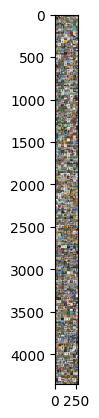

hamster bowl  rocket rocket bridge tiger tulip elephant trout girl  raccoon poppy tank  lizard bridge plain mountain rabbit wolf  wolf  skyscraper kangaroo shrew bottle palm_tree raccoon cattle tiger boy   girl  ray   skunk rocket porcupine skyscraper ray   boy   maple_tree snail shark wolf  seal  streetcar willow_tree castle keyboard worm  bed   worm  possum raccoon wolf  spider pear  kangaroo tulip bear  road  oak_tree dinosaur plate porcupine seal  sea   tulip ray   tulip ray   bowl  crab  turtle bear  whale cattle plate bee   can   palm_tree can   rabbit clock cockroach leopard shark tank  bowl  chimpanzee dinosaur butterfly palm_tree train baby  rabbit lamp  tank  baby  clock shrew dolphin otter girl  beetle skunk tank  cattle bed   pickup_truck mushroom orchid apple bus   lobster sweet_pepper cockroach lion  boy   man   beaver raccoon pine_tree motorcycle tank  baby  snail pickup_truck plain rabbit sweet_pepper road  cattle butterfly cloud elephant man   worm  leopard tank  keybo

In [7]:
# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainLoader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp',
    'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain',
    'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal',
    'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper',
    'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle',
    'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(args.batch_size)))

In [8]:
print(type(images), images.shape) #batchsize =4, channnel=3, widthxheight=32x32
print(type(labels), labels.shape, labels)

<class 'torch.Tensor'> torch.Size([1024, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([1024]) tensor([36, 10, 69,  ..., 62, 85, 75])


Model define

In [9]:
def conv3x3(in_channels, out_channels, stride=1):
  return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

def conv1x1(in_channels, out_channels, stride=1):
  return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)

In [10]:
class BasicBlock(nn.Module):
  expansion = 1
  def __init__(self, in_channels, out_channels, stride=1, downsample=None):
    super(BasicBlock, self).__init__()
    self.conv1 = conv3x3(in_channels, out_channels, stride)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = conv3x3(out_channels, out_channels)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.downsample = downsample
    self.stride = stride

  def forward(self, x):
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    if self.downsample is not None:
      identity = self.downsample(x)

    out += identity
    out = self.relu(out)

    return out

In [44]:
class BottleNeck(nn.Module):
  expansion = 4
  def __init__(self, in_channels, out_channels, stride=1, downsample=None):
    super(BottleNeck, self).__init__()
    self.conv1 = conv1x1(in_channels, out_channels)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = conv3x3(out_channels, out_channels, stride)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.conv3 = conv1x1(out_channels, out_channels*self.expansion)
    self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
    self.relu = nn.ReLU()
    self.downsample = downsample
    self.stride = stride

  def forward(self, x):
    identity = x
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)
    out = self.conv3(out)
    out = self.bn3(out)
    if self.downsample is not None:
      identity = self.downsample(x)
    out += identity
    out = self.relu(out)
    return out

In [41]:
class ResNetModel(nn.Module):
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=True):
        super(ResNetModel, self).__init__()

        self.in_channels = 64  # 초기 입력 채널

        # 첫 번째 큰 7x7 Conv 레이어 (stride 2, padding 3으로 설정)
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet block 쌓기
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Average pooling 후 fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),  # 50% Dropout 추가
            nn.Linear(512 * block.expansion, num_classes)
        )

        # Zero-initialize the last BN in each residual block (if zero_init_residual=True)
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, BottleNeck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        """ ResNet block을 쌓는 함수 """
        downsample = None
        # 채널을 확장하거나 stride가 2인 경우 downsample 필요
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.in_channels, out_channels * block.expansion, stride),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        # 첫 번째 블록에 대해 downsample 적용 (필요시)
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion  # 채널을 업데이트

        # 나머지 블록들
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # Flatten to (batch_size, 512 * block.expansion)
        x = self.fc(x)

        return x

# Example of building ResNet variants
def resnet18(num_classes=1000):
    return ResNetModel(BasicBlock, [2, 2, 2, 2], num_classes)

def resnet34(num_classes=1000):
    return ResNetModel(BasicBlock, [3, 4, 6, 3], num_classes)

def resnet50(num_classes=1000):
    return ResNetModel(BottleNeck, [3, 4, 6, 3], num_classes)

def resnet101(num_classes=1000):
    return ResNetModel(BottleNeck, [3, 4, 23, 3], num_classes)

def resnet152(num_classes=1000):
    return ResNetModel(BottleNeck, [3, 8, 36, 3], num_classes)


Loss and optimizer

Experiment

In [13]:
def train(model : nn.Module, loader:torch.utils.data.DataLoader, criterion:nn.Module, optimizer:optim.Optimizer):
    running_loss=0
    total=0
    correct = 0
    model.train()
    for inputs, labels in loader:
        inputs, labels = inputs.to(args.device), labels.to(args.device)

        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # 정확도 계산
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    loss = running_loss/len(loader)
    accuracy = 100. * correct / total
    return loss, accuracy

#model = resnet18(num_classes=100)
#model.to(args.device)
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
#loss, accuracy = train(model, trainLoader, criterion, optimizer)
#print(loss, accuracy)

In [14]:
def evaluate(model : nn.Module, loader:torch.utils.data.DataLoader, criterion:nn.Module):
    val_loss=0
    total=0
    correct = 0
    model.eval()

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(args.device), labels.to(args.device)

            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            # 정확도 계산
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = val_loss/len(loader)
    accuracy = 100. * correct / total
    return loss, accuracy

#loss, accuracy = train(model, validateLoader, criterion)
#print(loss, accuracy)

In [40]:
def experiment():
    if(args.model == 'resnet18'):
      model = resnet18(num_classes=100)
    elif(args.model == 'resnet34'):
      model = resnet34(num_classes=100)
    elif(args.model == 'resnet50'):
      model = resnet50(num_classes=100)
    elif(args.model == 'resnet101'):
      model = resnet101(num_classes=100)
    elif(args.model == 'resnet152'):
      model = resnet152(num_classes=100)
    model.to(args.device)
    criterion = nn.CrossEntropyLoss()
    if(args.optimizer == 'adam'):
      optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    elif(args.optimizer == 'sgd'):
      optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
    else:
      print("invalid optimizer")

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    for epoch in range(args.epoch):
        trainLoss, trainAccuracy = train(model, trainLoader, criterion, optimizer)
        run["metrics/train_loss"].log(trainLoss)
        run["metrics/train_acc"].log(trainAccuracy)
        valLoss, valAccuracy = evaluate(model, validateLoader, criterion)
        run["metrics/val_loss"].log(valLoss)
        run["metrics/val_acc"].log(valAccuracy)

        scheduler.step(valLoss)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"[{epoch}] trainLoss:{trainLoss:.4f}, trainAcc:{trainAccuracy}, valLoss:{valLoss:.4f}, valAcc:{valAccuracy}, lr:{current_lr}")

    _, testAccuracy = evaluate(model, testLoader, criterion)
    return model, testAccuracy

#experiment()


In [47]:
args.lr = 0.1
args.weight_decay = 5e-4
args.optimizer = 'sgd'
args.model = 'resnet50'
args.epoch = 50
params = vars(args)

# with 블록을 사용하여 자동으로 run.stop() 호출
with neptune.init_run(
    project="sy-hwang/simple-CNN",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyYzQ4YjZkMy04ODc2LTQ3NzItODY1Zi04MWVhMzdhZmJmNTEifQ==",
    name="RESNET50Model with SGD Scheduler",
) as run:  # with 블록을 사용
    run["parameters"] = params
    model, acc = experiment()
    run["test_acc"] = acc
    run["model/CNN"] = neptune.types.File.as_pickle(model)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/sy-hwang/simple-CNN/e/SIM-44
[0] trainLoss:4.5860, trainAcc:3.1925, valLoss:4.9660, valAcc:2.92, lr:0.1
[1] trainLoss:4.4098, trainAcc:5.2775, valLoss:4.1858, valAcc:7.3, lr:0.1
[2] trainLoss:3.8728, trainAcc:11.105, valLoss:3.6948, valAcc:14.23, lr:0.1
[3] trainLoss:3.5351, trainAcc:16.7975, valLoss:3.9439, valAcc:10.8, lr:0.1
[4] trainLoss:3.4232, trainAcc:17.7425, valLoss:3.2612, valAcc:20.61, lr:0.1
[5] trainLoss:3.0850, trainAcc:23.4975, valLoss:3.1585, valAcc:23.02, lr:0.1
[6] trainLoss:2.8644, trainAcc:27.5675, valLoss:3.3804, valAcc:19.2, lr:0.1
[7] trainLoss:2.8091, trainAcc:28.8625, valLoss:2.7704, valAcc:30.57, lr:0.1
[8] trainLoss:2.4865, trainAcc:35.4575, valLoss:2.8750, valAcc:28.77, lr:0.1
[9] trainLoss:2.3804, trainAcc:37.3225, valLoss:2.7575, valAcc:30.85, lr:0.1
[10] trainLoss:2.1490, trainAcc:41.8025, valLoss:2.6518, valAcc:33.42, lr:0.1
[11] trainLoss:1.9176, trainAcc:47.1675, valLoss:2

Traceback (most recent call last):
  File "<ipython-input-47-32de7e41d8b1>", line 15, in <cell line: 9>
    model, acc = experiment()
  File "<ipython-input-40-4dd3f03af358>", line 27, in experiment
    valLoss, valAccuracy = evaluate(model, validateLoader, criterion)
  File "<ipython-input-14-47f0d17095bd>", line 14, in evaluate
    val_loss += loss.item()
KeyboardInterrupt


[neptune] [info   ] All 2 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/sy-hwang/simple-CNN/e/SIM-44/metadata


KeyboardInterrupt: 

In [36]:
run.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/sy-hwang/simple-CNN/e/SIM-38/metadata
